# TASK - NAMED ENTITY RECOGNITION

## IMPORTS

In [1]:
import pandas as pd
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vemul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vemul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# ENSURING SPACY MODEL IS LOADED AND NOT CAUSING ERROR

In [4]:
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading 'en_core_web_sm' model...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

In [5]:
# Load each dataset (assuming they are CSV files)
gossip_fake = pd.read_csv("gossipcop_fake.csv")
gossip_real = pd.read_csv("gossipcop_real.csv")
politifact_fake = pd.read_csv("politifact_fake.csv")
politifact_real = pd.read_csv("politifact_real.csv")

# Add labels to each dataset
gossip_fake["label"] = "fake"
gossip_real["label"] = "real"
politifact_fake["label"] = "fake"
politifact_real["label"] = "real"

# Add domain labels
gossip_fake["domain"] = "gossip"
gossip_real["domain"] = "gossip"
politifact_fake["domain"] = "politifact"
politifact_real["domain"] = "politifact"

In [6]:
combined_df = pd.concat([gossip_fake, gossip_real, politifact_fake, politifact_real], ignore_index=True)

In [7]:
print("Indexe :",combined_df.columns)
print(combined_df.shape)

Indexe : Index(['id', 'news_url', 'title', 'tweet_ids', 'label', 'domain'], dtype='object')
(23196, 6)


In [8]:
combined_df

,id,news_url,title,tweet_ids,label,domain
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,fake,gossip
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,fake,gossip
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,fake,gossip
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,fake,gossip
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,fake,gossip
...,...,...,...,...,...,...
23191,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,real,politifact
23192,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,real,politifact
23193,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,real,politifact
23194,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,real,politifact


In [9]:
stop_words = set(stopwords.words("english"))

## Removing Null Values

In [10]:
df = combined_df.dropna()
print(df.shape)

(21407, 6)


## TEXT PREPROCESSING

In [11]:
def preprocess_text(text):
    # 1. Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # 2. Remove special characters and punctuation (retain alphanumeric and whitespace)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    # 3. Convert to lowercase
    text = text.lower().strip()
    # 4. Remove extra whitespace
    text = re.sub(r"\s+", " ", text)
    # 5. Tokenize text
    tokens = word_tokenize(text)
    # 6. Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    
    # Return cleaned and lemmatized text as a single string
    return " ".join(lemmatized_tokens)


In [12]:
df["title_clean"] = df["title"].apply(preprocess_text)
df["url_clean"] = df["news_url"].apply(preprocess_text)

C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\1018924059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_clean"] = df["title"].apply(preprocess_text)
C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\1018924059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["url_clean"] = df["news_url"].apply(preprocess_text)


In [13]:
df['popularity'] = df['tweet_ids'].apply(lambda x: len(x.split('\t')))

C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\647534437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['popularity'] = df['tweet_ids'].apply(lambda x: len(x.split('\t')))


In [14]:
df

,id,news_url,title,tweet_ids,label,domain,title_clean,url_clean,popularity
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,fake,gossip,miley cyrus liam hemsworth secretly get marry,www dailymail co uk tvshowbiz article 5874213 ...,97
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,fake,gossip,paris jackson cara delevingne enjoy night matc...,hollywoodlife com 2018 05 05 paris jackson car...,15
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,fake,gossip,celebrity join tax march protest donald trump,variety com 2017 biz news tax march donald tru...,86
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,fake,gossip,cindy crawford daughter kaia gerber wear wig d...,www dailymail co uk femail article 3499192 blo...,14
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,fake,gossip,full list 2018 oscar nomination variety,variety com 2018 film news list 2018 oscar nom...,66
...,...,...,...,...,...,...,...,...,...
23189,politifact6931,http://www.politifact.com/truth-o-meter/promis...,The Obameter: Introduce a comprehensive immigr...,21096374968\t21096771824\t9413452992876544\t12...,real,politifact,obameter introduce comprehensive immigration b...,http www politifact com truth meter promise ob...,137
23190,politifact13619,http://www.cnn.com/2017/01/05/politics/border-...,"Trump asking Congress, not Mexico, to pay for ...",817357495047979008\t817357627566985217\t817357...,real,politifact,trump ask congress mexico pay border wall,http www cnn com 2017 01 05 politic border wal...,976
23192,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,real,politifact,change believe,https web archive org web 20080131000131 http ...,182
23194,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,real,politifact,romney prolife conversion myth reality june 14,http www youtube com watch v ehymplwy6hy,1


In [15]:
df.shape

(21407, 9)

In [16]:
popular_articles = df[df['popularity'] > 30]  # Articles with more than 30 tweet IDs

In [17]:
popular_articles.shape

(12537, 9)

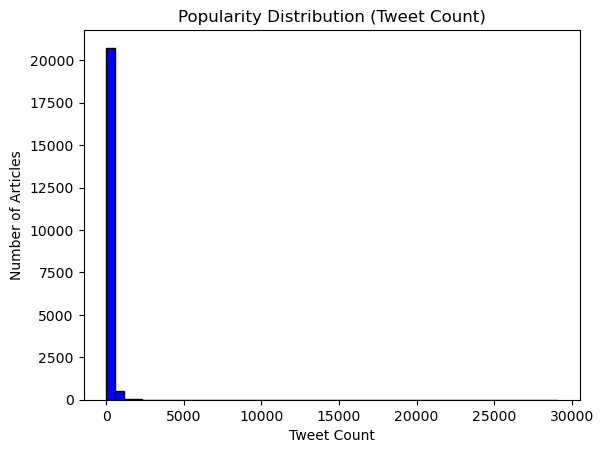

In [18]:
# Plot the distribution of popularity (tweet count)
plt.hist(df['popularity'], bins=50, color='blue', edgecolor='black')
plt.title('Popularity Distribution (Tweet Count)')
plt.xlabel('Tweet Count')
plt.ylabel('Number of Articles')
plt.show()

In [19]:
df['label_numeric'] = df['label'].apply(lambda x: 1 if x == 'real' else 0)  # 'real' = 1, 'fake' = 0

C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\1320383454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_numeric'] = df['label'].apply(lambda x: 1 if x == 'real' else 0)  # 'real' = 1, 'fake' = 0


### NER ( NAMED ENTITY RECOGNITION)

In [20]:
def extract_named_entities(title):
    doc = nlp(title)
    return [ent.text for ent in doc.ents]
df['named_entities'] = df['title_clean'].apply(extract_named_entities)

C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\1337953251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['named_entities'] = df['title_clean'].apply(extract_named_entities)


In [21]:
correlation = df[['popularity', 'label_numeric']].corr()

# Display the correlation
print("Correlation between Popularity and Fake/Real News:")
print(correlation)


Correlation between Popularity and Fake/Real News:
               popularity  label_numeric
popularity       1.000000      -0.052765
label_numeric   -0.052765       1.000000


# BAR CHART REPRESENTING POPULARITY

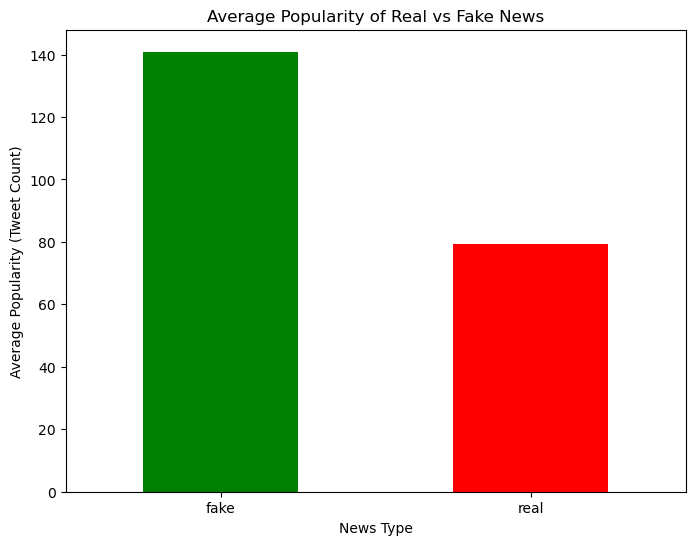

In [22]:
plt.figure(figsize=(8, 6))
df.groupby('label')['popularity'].mean().plot(kind='bar', color=['green', 'red'])
plt.title('Average Popularity of Real vs Fake News')
plt.xlabel('News Type')
plt.ylabel('Average Popularity (Tweet Count)')
plt.xticks(rotation=0)
plt.show()

In [23]:
df['num_named_entities'] = df['named_entities'].apply(len)

C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\3454903016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_named_entities'] = df['named_entities'].apply(len)


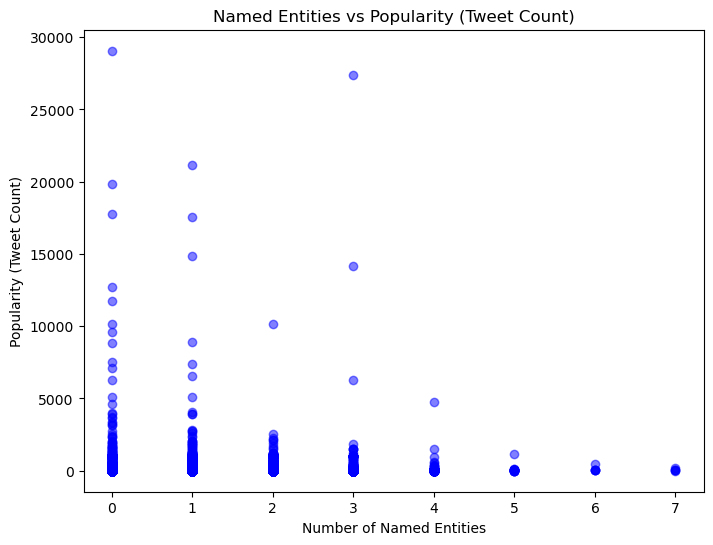

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(df['num_named_entities'], df['popularity'], alpha=0.5, color='blue')
plt.title('Named Entities vs Popularity (Tweet Count)')
plt.xlabel('Number of Named Entities')
plt.ylabel('Popularity (Tweet Count)')
plt.show()

In [25]:
# CORRELATION MATRIX

C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\3174206407.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


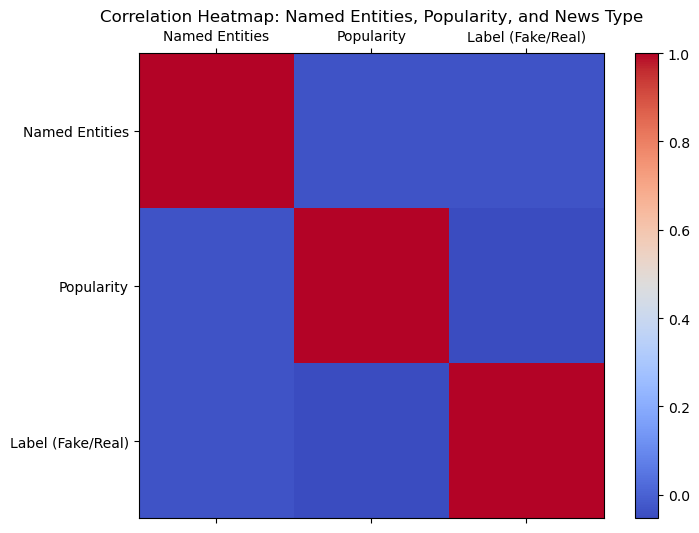

In [26]:
corr_matrix = df[['num_named_entities', 'popularity', 'label_numeric']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.matshow(corr_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title('Correlation Heatmap: Named Entities, Popularity, and News Type')
plt.xticks([0, 1, 2], ['Named Entities', 'Popularity', 'Label (Fake/Real)'])
plt.yticks([0, 1, 2], ['Named Entities', 'Popularity', 'Label (Fake/Real)'])
plt.tight_layout()
plt.show()

### THESE ARE BASIC ALGORITHMS TO CREATE A MODEL FOR REPRESENTING DATA OF THIS FORMAT

# USING RANDOMFOREST

In [27]:
X = df[['popularity', 'num_named_entities']] 
# Features: popularity, number of named entities
y = df['label_numeric']  
# Target: real (1) or fake (0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=5)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

feature_importances = clf.feature_importances_
print("\nFeature Importances:")
print(f"Popularity: {feature_importances[0]}")
print(f"Number of Named Entities: {feature_importances[1]}")

Accuracy: 0.8094348435310602

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.43      0.53      1576
           1       0.84      0.93      0.88      4847

    accuracy                           0.81      6423
   macro avg       0.75      0.68      0.70      6423
weighted avg       0.80      0.81      0.79      6423


Confusion Matrix:
[[ 684  892]
 [ 332 4515]]

Feature Importances:
Popularity: 0.979248675795227
Number of Named Entities: 0.020751324204772943


# USING ADABOOST DECISIONTREE

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df[['popularity', 'num_named_entities']]  # Features: popularity, number of named entities
y = df['label_numeric']  # Target: real (1) or fake (0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_estimator = DecisionTreeClassifier(max_depth=1)  # Shallow trees are typically used with AdaBoost
adaboost = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

class_weights = {0: 1, 1: 5}  
# Giving more weight to the minority class (fake news, label=0)

adaboost.fit(X_train_scaled, y_train, sample_weight=y_train.map(class_weights))

y_pred = adaboost.predict(X_test_scaled)

# Step 12: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

C:\Users\vemul\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7615600186828585

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.04      0.07      1055
           1       0.76      1.00      0.86      3227

    accuracy                           0.76      4282
   macro avg       0.83      0.52      0.47      4282
weighted avg       0.80      0.76      0.67      4282


Confusion Matrix:
[[  38 1017]
 [   4 3223]]


# LOGISTIC REGRESSION

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
df['label'] = df['label'].map({'fake': 0, 'real': 1})

# Split data into features (X) and target (y)
X = df['title_clean']  # Using 'title_clean' as feature
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# TF-IDF Vectorization: Convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000)

# Logistic Regression Model
lr = LogisticRegression(class_weight='balanced', random_state=42)

pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000),  # Convert text to TF-IDF features
    LogisticRegression(class_weight='balanced', random_state=42)
)

# Fit the model
pipeline.fit(X_train, y_train)
# Make predictions on the test set



C:\Users\vemul\AppData\Local\Temp\ipykernel_14320\813940774.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map({'fake': 0, 'real': 1})


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [31]:
y_pred = pipeline.predict(X_test)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Logistic Regression
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'tfidfvectorizer__max_features': [2000, 5000, 10000]
}

# Create the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Classification Report (Tuned):")
print(classification_report(y_test, y_pred_best))

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.73      0.65      1586
           1       0.90      0.83      0.86      4837

    accuracy                           0.80      6423
   macro avg       0.74      0.78      0.76      6423
weighted avg       0.82      0.80      0.81      6423

Confusion Matrix:
[[1158  428]
 [ 834 4003]]
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'logisticregression__C': 1, 'tfidfvectorizer__max_features': 10000}
Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.59      0.72      0.65      1586
           1       0.90      0.84      0.87      4837

    accuracy                           0.81      6423
   macro avg       0.75      0.78      0.76      6423
weighted avg       0.82      0.81      0.81      6423



# SUPPORT VECTOR MACHINE

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with TF-IDF and SVM
pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000),  # Convert text to TF-IDF features
    SVC(kernel='linear', class_weight='balanced', random_state=42)
)

# Fit the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('svc',
                 SVC(class_weight='balanced', kernel='linear',
                     random_state=42))])

In [33]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.74      0.63      1586
           1       0.90      0.81      0.85      4837

    accuracy                           0.79      6423
   macro avg       0.73      0.77      0.74      6423
weighted avg       0.82      0.79      0.80      6423

Confusion Matrix:
[[1170  416]
 [ 943 3894]]


In [34]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for SVM
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],  # Kernel type
    'tfidfvectorizer__max_features': [2000, 5000, 10000]  # Features in TF-IDF
}

# Create GridSearchCV for model selection
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Classification Report (Tuned):")
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'svc__C': 10, 'svc__kernel': 'rbf', 'tfidfvectorizer__max_features': 10000}
Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      1586
           1       0.86      0.94      0.90      4837

    accuracy                           0.84      6423
   macro avg       0.80      0.74      0.77      6423
weighted avg       0.83      0.84      0.83      6423



In [ ]:
`